<a href="https://colab.research.google.com/github/daliaydom/Aprendizaje-Profundo/blob/main/Ejercicio3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Curso de aprendizaje profundo
## Redes densas
### Dalia Yvette Domínguez Jiménez

#### Ejercicio 3: Regresión lineal con PyTorch

Entrena y evalúa un modelo de regresión lineal para el conjunto de datos de calificaciones que
considere los dos atributos de entrada.

**Importamos bibliotecas**

In [1]:
import math
# sistema de archivos
import os
# números aleatorios
import random

# gráficas
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# csv
import pandas as pd

# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset

**Descargamos los datos**

In [2]:
URL = 'https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/2023-1/data/califs/califs.csv'
# data_dir = '../data'
filepath = os.path.join('', 'califs.csv')

def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [3]:
# os.makedirs(data_dir) #window
# ! mkdir {data_dir}
! wget -nc {URL} -O {'califs.csv'}

--2022-09-28 06:18:02--  https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/2023-1/data/califs/califs.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 666 [text/plain]
Saving to: ‘califs.csv’

califs.csv          100%[===================>]     666  --.-KB/s    in 0s      

2022-09-28 06:18:03 (25.3 MB/s) - ‘califs.csv’ saved [666/666]



Cargamos los datos.

In [4]:
df = pd.read_csv('califs.csv')
df.head(5)

,prev,horas,calif
0,5.6,8.2,5.1
1,6.7,9.3,5.9
2,5.1,10.0,5.4
3,5.7,10.4,6.5
4,7.1,10.4,6.7


### 3.1 Grafica los datos en 3D

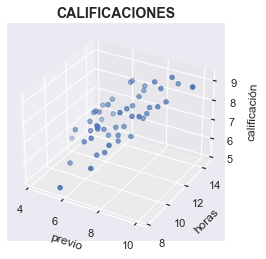

In [ ]:
sns.set(style = "darkgrid")

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x,y,z = df['prev'], df['horas'], df['calif']

ax.set_xlabel('previo')
ax.set_ylabel('horas')
ax.set_zlabel('calificación')
ax.set_title("CALIFICACIONES",fontsize=14,fontweight="bold")
ax.scatter(x, y, z)

plt.show()

<ipython-input-6-1064030c5005>:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.figure.colorbar(sm)


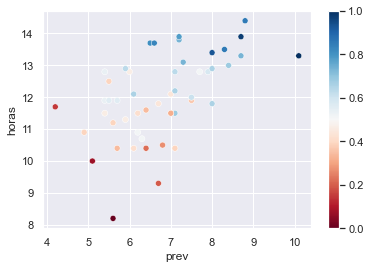

In [ ]:
sns.set()
ax = sns.scatterplot(x='prev', y='horas', hue='calif', palette='RdBu', data=df)
sm = plt.cm.ScalarMappable(cmap="RdBu")
# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)
plt.show()

### 3.2 Realiza la definición de la arquitectura usando tanto la interfaz de alto como la de medio nivel.

Obtener los tensores de entrenamiento, de caracteristicas X y de targets Y:

In [ ]:
x_trn = np.array(df.iloc[:,:2], dtype="float32")
y_trn = np.array(df.iloc[:,-1], dtype="float32")[..., np.newaxis]

x_trn = torch.tensor(x_trn)
y_trn = torch.tensor(y_trn)

print(x_trn.shape)
print(y_trn.shape)

torch.Size([50, 2])
torch.Size([50, 1])


In [ ]:
ds = TensorDataset(x_trn, y_trn)
ds[0]

(tensor([5.6000, 8.2000]), tensor([5.1000]))

Para ver el funcionamiento de la tubería de datos imprimimos la forma de cada lote y su primer elemento.

In [ ]:
def build_dl(batch_size=16, shuffle=True):
    return DataLoader(ds, batch_size=batch_size, shuffle=True)

# creamos un DataLoader
dl = build_dl()

x, y = next(iter(dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([16, 2]) dtype=torch.float32
y shape=torch.Size([16, 1]) dtype=torch.float32


Utilizamos el optimizador de desenso por gradiante estocástico para entrenar nuestro modelo. Además agregamos a las funciones algunos hiperparámetros como parámetros de entrada como: el número de neuronas en la capa oculta (n1), la función de activación (fa) y la tasa de aprendizaje (a).
También que las funciones regresen el historial de perdidas de cada epoca de entrenamiento.

In [ ]:
# optimizador
def train(model, dl, a=1e-3, epochs=5):

    opt = optim.SGD(model.parameters(), lr=a)

    # historial de pérdida
    loss_epoch = []

    # ciclo de entrenamiento
    for epoch in range(epochs):

        # historial
        loss_hist = []
        
        # entrenamiento de una época
        for x, y_true in dl:
            # hacemos inferencia para obtener los logits
            y_lgts = model(x)
            # calculamos de pérdida
            loss = F.mse_loss(y_lgts, y_true)
            # vaciamos los gradientes
            opt.zero_grad()
            # retropropagamos
            loss.backward()
            # actulizamos parámetros
            opt.step()

            # guardamos historial de pérdida
            loss_hist.append(loss.item() * 100)
            
        # imprimimos la pérdida de la época
        loss = np.mean(loss_hist)
        loss_epoch.append(loss)
        #print(f'E{epoch:02} loss=[{loss:6.2f}]')
    return loss_epoch
        
def train_model(build_model, n1=2, fa=nn.ReLU(), a=1e-3, epochs=5):
    set_seed()
    dl = build_dl()
    model = build_model(n1, fa)
    loss_epoch=train(model, dl, a, epochs)
    return loss_epoch, model

#### 3.2.1 Alto nivel (similar a Keras)

Creamos una red densa con dos entradas, una capa oculta de dos neuronas, con una función de activación ReLu y una capa de salida de una neurona.
Agregamos el número de neuronas de la capa oculta como parámetro, así como la función de activación. 

In [ ]:
def build_high(n1=2, fa=nn.ReLU()):
    model = nn.Sequential(
        nn.Linear(2, n1),
        fa,
        nn.Linear(n1, 1),
    )
    return model

build_high()

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2, out_features=1, bias=True)
)

#### 3.2.2 Medio nivel (Chainer, tensorflow.keras.model)

Creamos una red densa con dos entradas, una capa interna de dos neuronas, con una función de activación ReLu y una capa de salida de una neurona.

In [ ]:
class LinRegMed(nn.Module):

    #se define el inicializador
    def __init__(self, n1 = 2, fa=F.relu):
        # se llama al inicializador de la clase padre
        super().__init__()
        # importante: se definen las capas como atributos de la clase
        self.funact = fa
        self.fc1 = nn.Linear(2, n1)
        self.fc2 = nn.Linear(n1, 1)

    # método para inferencia
    def forward(self, x):
        x = self.fc1(x)
        x = self.funact(x)
        x = self.fc2(x)
        return x

def build_med(n1=2,fa=F.relu):
    return LinRegMed(n1=n1,fa=fa)

build_med(n1=5,fa=F.sigmoid)

LinRegMed(
  (fc1): Linear(in_features=2, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=1, bias=True)
)

### 3.3 Entrenando los modelos con distintos parámetros

#### 3.3.1 Alto nivel

###### **Con diferentes numero de neuronas**

Se puede observar que para algunos casos el aumentar el número de neuronas de la capa oculta la perdida decrece más rápido. Sin embargo, si utilizamos 7 neuronas, obtenemos el decrecimiento de la pérdida más rápido que al usar 8 o 9 neuronas, pues antes de dos épocas de entrenamiento, este tiene el valor de pérdida más bajo a comparación de los otros modelos.
Después de tres épocas de entrenamiento, todos los modelos tienen perdidas similares y ya no decrecen. Por lo que podríamos elegir un modelo con pocas neuronas (mayor a 1), pues dentro de poco numero de epocas tendra un rendimiento similar que los modelos con muchas neuronas, los cuales consideran muchos pesos que ajustar.

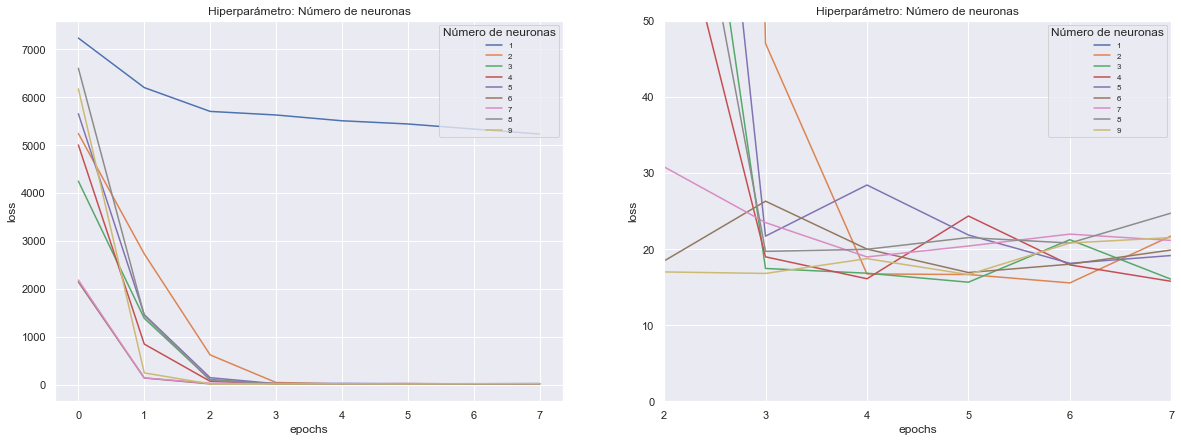

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(20,7))

ne=8
epochs = np.arange(ne)
list_param = np.arange(1,10)

plt.subplot(1, 2, 1)
for param in list_param:
    losses, m = train_model(build_high,n1=param,epochs=ne)
    axs[0].plot(epochs, losses, label = param)
    axs[1].plot(epochs, losses, label = param)
axs[0].set_xlabel('epochs')
axs[1].set_xlabel('epochs')
axs[0].set_ylabel('loss')
axs[1].set_ylabel('loss')
axs[0].legend(title='Número de neuronas',loc='upper right',fontsize=8)
axs[1].legend(title='Número de neuronas',loc='upper right',fontsize=8)
axs[0].set_title('Hiperparámetro: Número de neuronas')
axs[1].set_title('Hiperparámetro: Número de neuronas')
axs[1].set_ylim((0,50))
axs[1].set_xlim((2,ne-1))
plt.show()


##### **Con diferente tasa de aprendizaje**

Se sintonizó entre qué intervalo tenía que encontrarse la tasa de aprendizaje para tener un desempeño óptimo. Y se puede observar, dentro de este rango, entre mayor sea la tasa de aprendizaje (1e-3) la perdida disminuye más rápido.

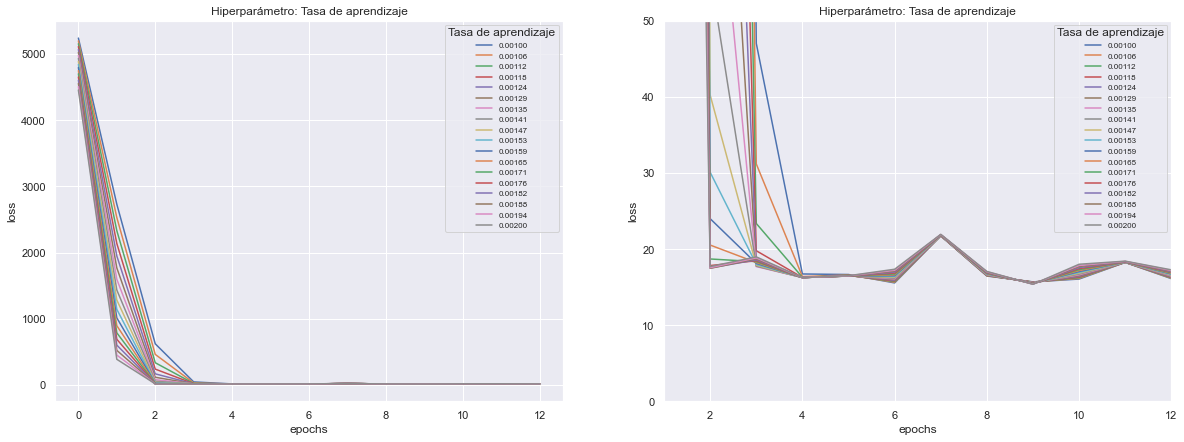

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(20,7))

ne=13
epochs = np.arange(ne)
list_param = np.linspace(0.001,0.002,18)

plt.subplot(1, 2, 1)
for param in list_param:
    losses, m = train_model(build_high,n1=2,epochs=ne, a=param)
    axs[0].plot(epochs, losses, label = f'{param:1.5f}')
    axs[1].plot(epochs, losses, label = f'{param:1.5f}')
axs[0].set_xlabel('epochs')
axs[1].set_xlabel('epochs')
axs[0].set_ylabel('loss')
axs[1].set_ylabel('loss')
axs[0].legend(title='Tasa de aprendizaje',loc='upper right',fontsize=8)
axs[1].legend(title='Tasa de aprendizaje',loc='upper right',fontsize=8)
axs[0].set_title('Hiperparámetro: Tasa de aprendizaje')
axs[1].set_title('Hiperparámetro: Tasa de aprendizaje')
axs[1].set_ylim((0,50))
axs[1].set_xlim((1,ne-1))
plt.show()

##### **Con diferente función de activación**

Utilizando otra función de activación, como la logística o una función saturada, el aprendizaje se hace mucho más lento con respecto a la función de activación ReLu, aunque no se trate de una red profunda.

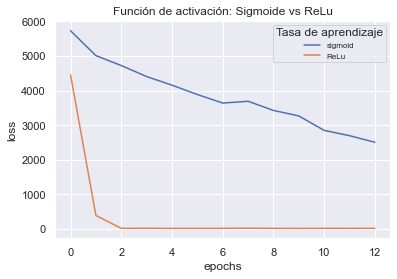

In [ ]:
ne=13
epochs = np.arange(ne)
list_param = np.linspace(0.001,0.002,18)

losses, m = train_model(build_high,n1=2,epochs=ne, a=2e-3, fa=nn.Sigmoid())
plt.plot(epochs, losses, label = 'sigmoid')
losses, m = train_model(build_high,n1=2,epochs=ne, a=2e-3)
plt.plot(epochs, losses, label = 'ReLu')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(title='Tasa de aprendizaje',loc='upper right',fontsize=8)
plt.title('Función de activación: Sigmoide vs ReLu')
plt.show()

#### 3.3.2 Medio Nivel

COn este nivel obtenemos resultados iguales a los obtenidos en alto nivel.

###### **Con diferentes numero de neuronas**

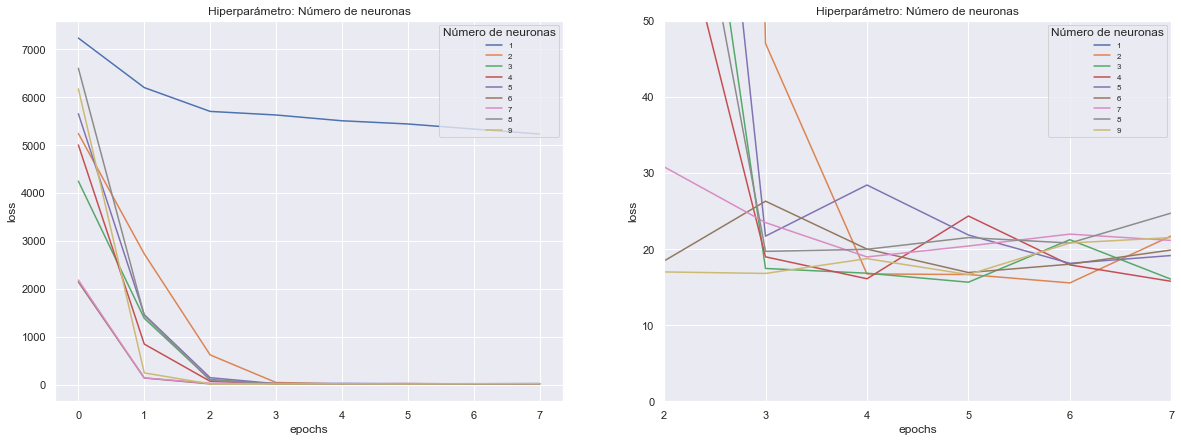

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(20,7))

ne=8
epochs = np.arange(ne)
list_param = np.arange(1,10)

plt.subplot(1, 2, 1)
for param in list_param:
    losses, m = train_model(build_med,fa=F.relu,n1=param,epochs=ne)
    axs[0].plot(epochs, losses, label = param)
    axs[1].plot(epochs, losses, label = param)
axs[0].set_xlabel('epochs')
axs[1].set_xlabel('epochs')
axs[0].set_ylabel('loss')
axs[1].set_ylabel('loss')
axs[0].legend(title='Número de neuronas',loc='upper right',fontsize=8)
axs[1].legend(title='Número de neuronas',loc='upper right',fontsize=8)
axs[0].set_title('Hiperparámetro: Número de neuronas')
axs[1].set_title('Hiperparámetro: Número de neuronas')
axs[1].set_ylim((0,50))
axs[1].set_xlim((2,ne-1))
plt.show()

##### **Con diferente tasa de aprendizaje**

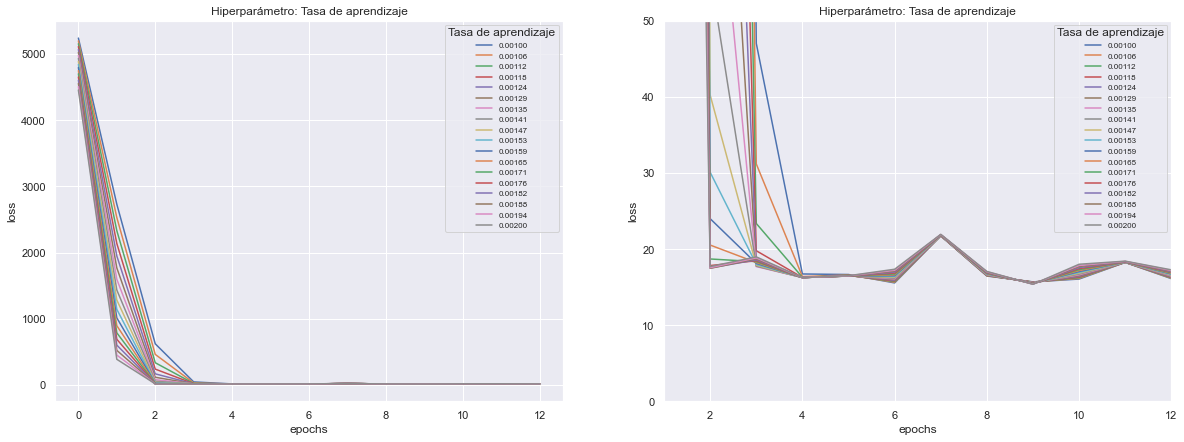

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(20,7))

ne=13
epochs = np.arange(ne)
list_param = np.linspace(0.001,0.002,18)

plt.subplot(1, 2, 1)
for param in list_param:
    losses, m = train_model(build_med,fa=F.relu,n1=2,epochs=ne, a=param)
    axs[0].plot(epochs, losses, label = f'{param:1.5f}')
    axs[1].plot(epochs, losses, label = f'{param:1.5f}')
axs[0].set_xlabel('epochs')
axs[1].set_xlabel('epochs')
axs[0].set_ylabel('loss')
axs[1].set_ylabel('loss')
axs[0].legend(title='Tasa de aprendizaje',loc='upper right',fontsize=8)
axs[1].legend(title='Tasa de aprendizaje',loc='upper right',fontsize=8)
axs[0].set_title('Hiperparámetro: Tasa de aprendizaje')
axs[1].set_title('Hiperparámetro: Tasa de aprendizaje')
axs[1].set_ylim((0,50))
axs[1].set_xlim((1,ne-1))
plt.show()

##### **Con diferente función de activación**

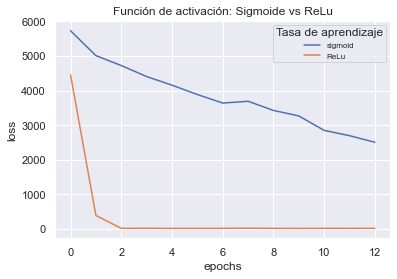

In [ ]:
ne=13
epochs = np.arange(ne)
list_param = np.linspace(0.001,0.002,18)

losses, m = train_model(build_high,n1=2,epochs=ne, a=2e-3, fa=nn.Sigmoid())
plt.plot(epochs, losses, label = 'sigmoid')
losses, m = train_model(build_high,n1=2,epochs=ne, a=2e-3)
plt.plot(epochs, losses, label = 'ReLu')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(title='Tasa de aprendizaje',loc='upper right',fontsize=8)
plt.title('Función de activación: Sigmoide vs ReLu')
plt.show()

### 3.4 Predicción de calificación

Realiza una predicción con tu modelo entrenado para la calificación que tendría un
alumno si sabemos que estudió durante 12 horas para el examen y en un examen previo
obtuvo 3 de calificación.

Vamos a entrenar el modelo de alto nivel, con una selección de parámetros: neuronas en la capa oculta 2, una función de activación ReLU, una tasa de aprendizaje de 1e-3 y con 7 epocas.

In [ ]:
loss, modelHigh = train_model(build_high,n1=2,fa=nn.ReLU(), a=1e-3, epochs=7)
loss

[5240.133953094482,
 2730.9080123901367,
 622.6653516292572,
 47.02812768518925,
 16.730719059705734,
 16.660653986036777,
 15.555250295437872]

Entrenamos el modelo de nivel medio con los mismos parámetros que el anterior.

In [ ]:
loss, modelMed=train_model(build_med,n1=2,fa=nn.ReLU(), a=1e-3, epochs=7)
loss

[5240.133953094482,
 2730.9080123901367,
 622.6653516292572,
 47.02812768518925,
 16.730719059705734,
 16.660653986036777,
 15.555250295437872]

Como se observa, ambos modelos tienen los mismos resultados en los valores de perdida, por lo que es de esperarse que también tengan la misma predicción.

In [ ]:
x_pred = torch.tensor([[3.0,12.0]])

In [ ]:
modelHigh(x_pred)

tensor([[6.7683]], grad_fn=<AddmmBackward0>)

In [ ]:
modelMed(x_pred)

tensor([[6.7683]], grad_fn=<AddmmBackward0>)

### Discusión

Se diseñaron dos redes: una de alto nivel y otra de bajo nivel. Por un lado, es mucho más fácil y rápido modificar la arquitectura al definarla en un alto nivel que a un nivel medio, o incluso bajo. Por otro lado, los niveles medio y bajo nos permiten una manipulación de más hiperparámetros de la arquitectura, lo cual podría tener algunas ventajas para mejorar el desempeño de los modelos.

Los hiperparámetros que se modificaron fueron: el número de neuronas, la tasa de aprendizaje y la función de activación:

- En el primer caso, en general, al aumentar el número de neuronas la pérdida caía más rápido, sin embargo, para todo el numero de neuronas se obtenía una perdida muy similar después de 3 o 4 épocas, así que se decidió tener una capa oculta con pocas neuronas por el costo computacional que implica tener más neuronas.
- Para el segundo caso, después de encontrar el rango de la tasa de aprendizaje adecuada, al tener valores más grandes (en el orden de 1e-3) la perdida decrecía más rápido, es decir, el aprendizaje era más rápido.
- Al cambiar la función de activación de una sigmoide a una ReLU, la pérdida decrece rápidamente, a pesar de que la red no es muy profunda, y podamos utilizar funciones saturadas, el desempeño del entrenamiento es mejor.

Otras condiciones que podríamos modificar al trabajar con niveles bajos son la inicialización de valores del descenso por gradiante. Aunque el trabajar con este nivel puede ser mucho más complicado.